# Wikipedia Web Traffic Forecasting

Project - B565-Fall-2023-Data Mining

Link to the dataset - https://www.kaggle.com/c/web-traffic-time-series-forecasting/data

## Table of Contents:

1. Loading the Dataset
2. Assessing Missing Data
3. Handling Missing Data
4. Outlier Detection
5. Data Analysis
   a. Overall, Monthly and Weekly trends
   b. Visualizing the Distribution of Average Web Traffic per Article
6. ARIMA
7. LSTM
   

In [1]:
import pandas as pd

# Load the dataset
file_path = 'web-traffic-time-series-forecasting/train_1.csv.zip'
data = pd.read_csv(file_path)

data.head()


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [2]:
# Calculate the number and percentage of missing values in each column
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100

# Create a summary DataFrame
missing_data_summary = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage Missing': missing_data_percentage
})

# Print the missing values summary
missing_data_summary.sort_values(by='Percentage Missing', ascending=False).head(10)


,Total Missing,Percentage Missing
2015-07-02,20816,14.349627
2015-07-01,20740,14.297236
2015-07-07,20664,14.244845
2015-07-05,20659,14.241399
2015-07-04,20654,14.237952
2015-07-03,20544,14.162123
2015-07-11,20525,14.149025
2015-07-12,20485,14.121451
2015-07-06,20483,14.120072
2015-07-13,20399,14.062166


# Handling Missing Data

## Handling Missing Data with Interpolation

Instead of filling missing values with the median, we'll use interpolation which provides a more nuanced approach, especially for time series data. The following code will interpolate missing values.


In [3]:
# Interpolating missing values
data_interpolated = data.copy()
for column in data_interpolated.columns[1:]:  # Skipping the 'Page' column
    data_interpolated[column] = data_interpolated[column].interpolate()

# Check the dataset after interpolation
data_interpolated.head()


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,23.5,10.0,7.0,49.5,12.0,17.0,9.5,13.0,17.5,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Outlier Detection

Outliers can significantly affect the performance of forecasting models. We will visualize the data to identify outliers and then use suitable methods to remove/modify them before training the models.

Number of pages with outliers: 97252


/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

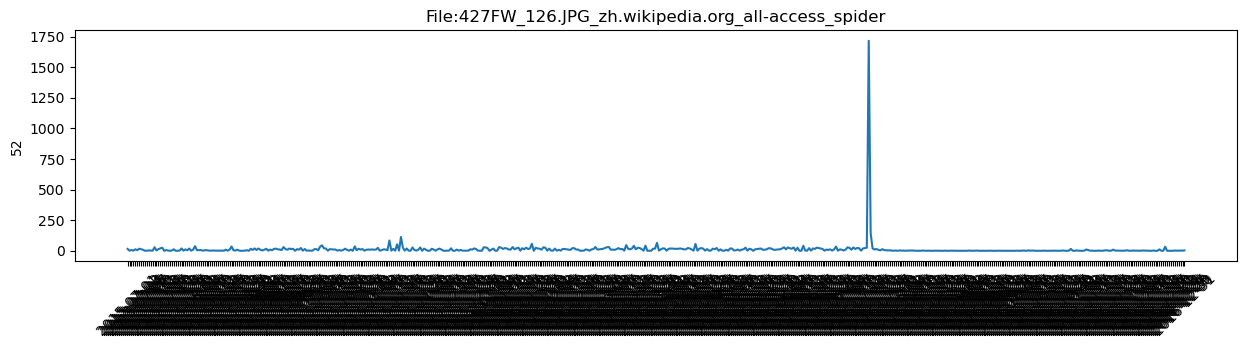

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

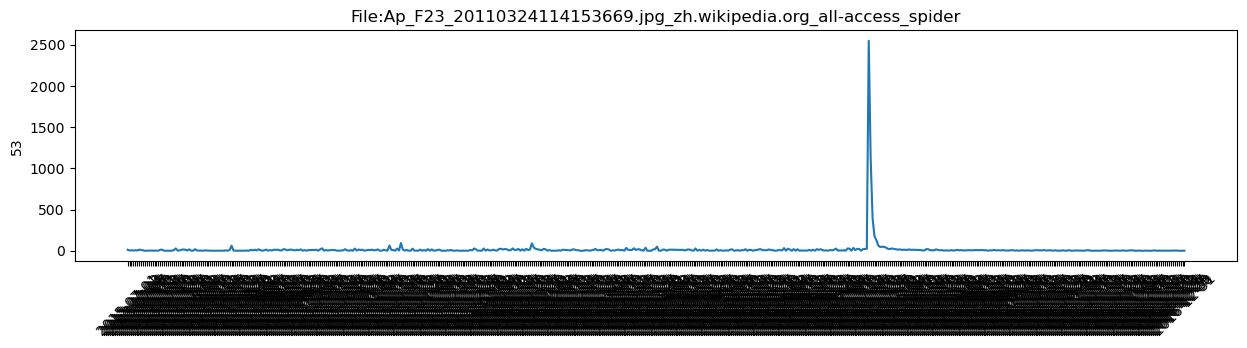

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

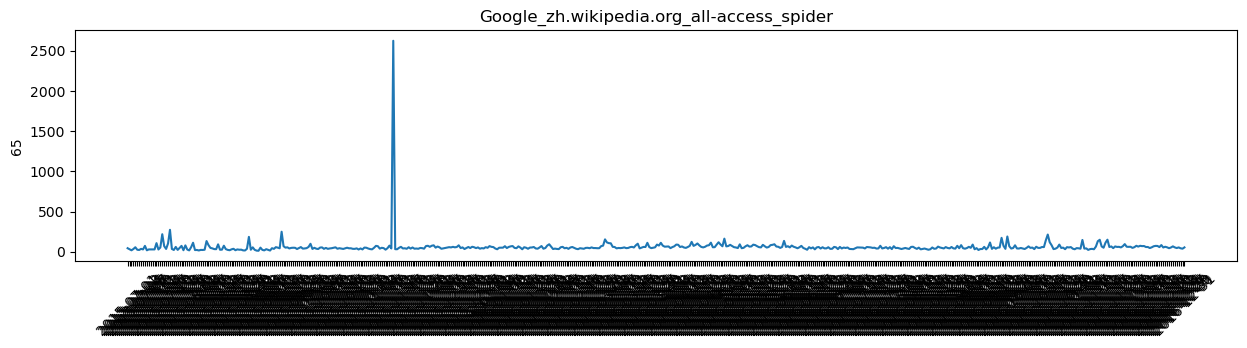

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

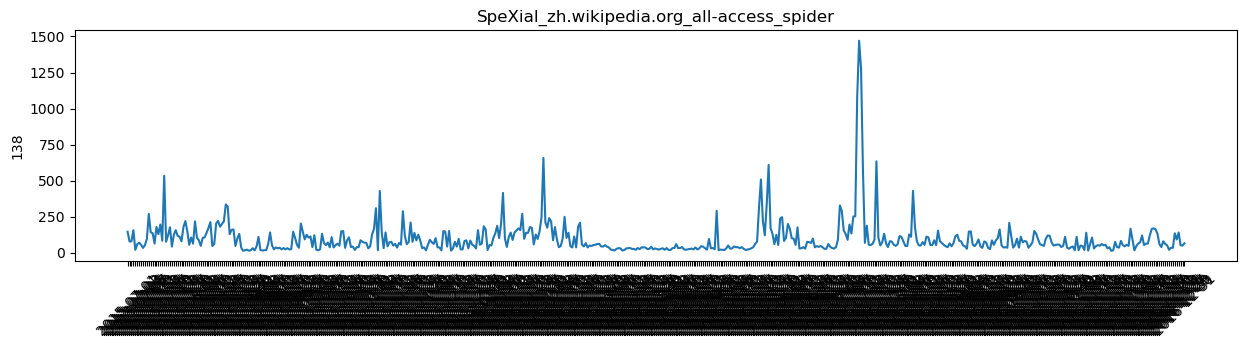

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

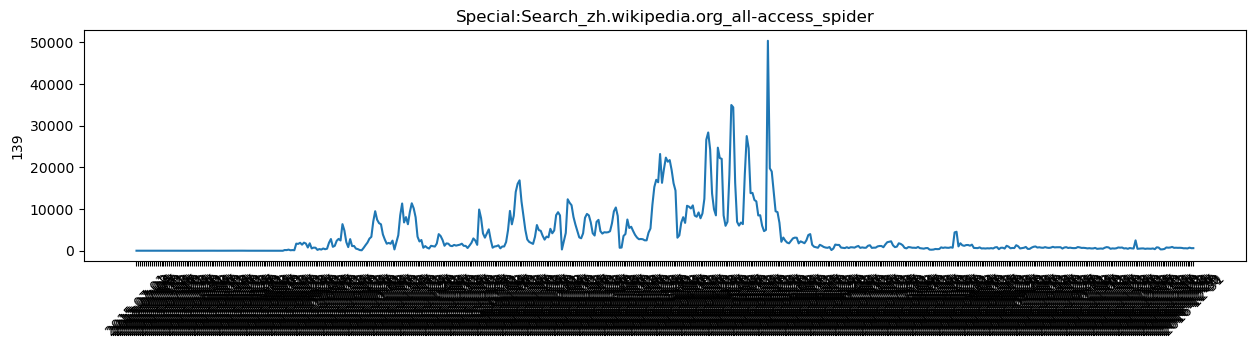

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect outliers using the Interquartile Range (IQR) method
def detect_outliers(data, threshold=1.5):
    outliers = []
    for column in data.columns[1:]:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (threshold * iqr)
        upper_bound = q3 + (threshold * iqr)
        outliers.extend(data[(data[column] < lower_bound) | (data[column] > upper_bound)].index.tolist())
    return list(set(outliers))

# Detecting outliers in the dataset
outliers = detect_outliers(data_interpolated)
print(f"Number of pages with outliers: {len(outliers)}")

# Plotting a few time series to visually inspect for outliers
sample_pages = data_interpolated.iloc[outliers[:5], 0]  # Selecting a few sample pages
for page in sample_pages:
    plt.figure(figsize=(15, 3))
    sns.lineplot(data=data_interpolated[data_interpolated['Page'] == page].iloc[0, 1:])
    plt.title(page)
    plt.xticks(rotation=45)
    plt.show()


## Outlier Cappping

We've opted to cap outliers instead of removing them because of the dual nature of outliers: while they can disproportionately influence predictions, they often carry valuable insights about unusual yet significant real-world events or trends. Capping allows us to soften the impact of these extreme values on our models, without losing the critical information they hold. This approach ensures that we maintain the comprehensive nature of our dataset, crucial for capturing the inherent variability and dynamics in the time series.

In [5]:
# Function to cap outliers using the specified percentiles
def cap_outliers(data, lower_percentile=5, upper_percentile=95):
    for column in data.columns[1:]:
        lower_bound = data[column].quantile(lower_percentile / 100.0)
        upper_bound = data[column].quantile(upper_percentile / 100.0)
        data[column] = data[column].clip(lower_bound, upper_bound)
    return data

# Capping outliers in the dataset
data_capped = cap_outliers(data_interpolated.copy())

# Displaying the first few rows of the dataset after capping
data_capped.head()


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,1.0,1.0,2.0,1.0,4.0,1.0,3.0,4.0,...,3.0,2.0,3.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,23.5,10.0,7.0,49.5,12.0,17.0,9.5,13.0,17.5,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Analysis

## Overall, Monthly and Weekly trends

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

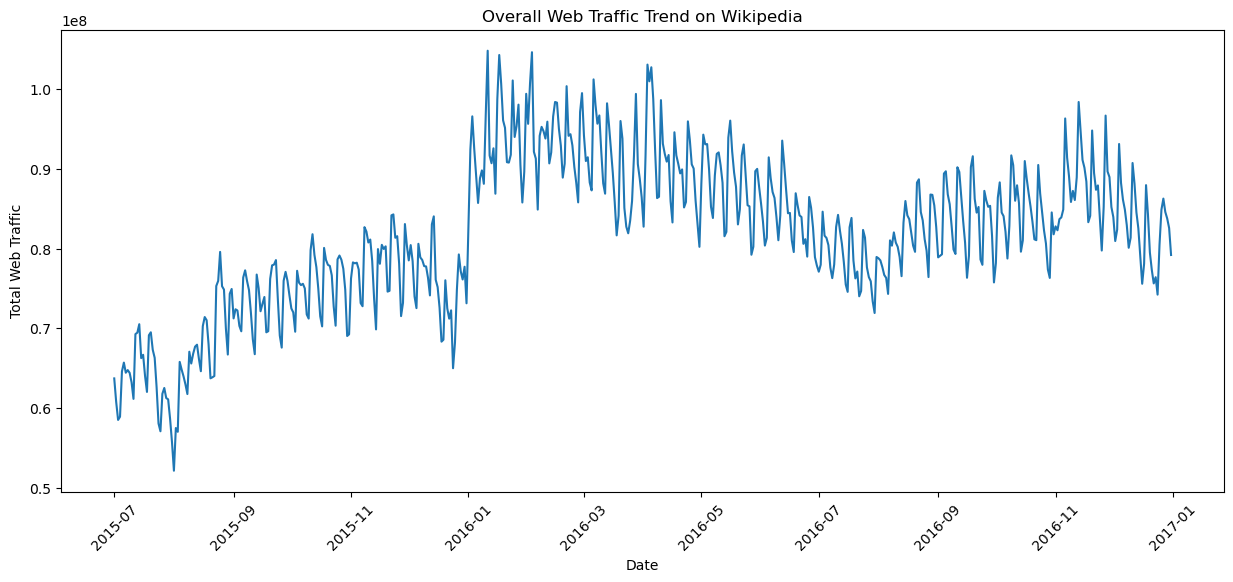

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

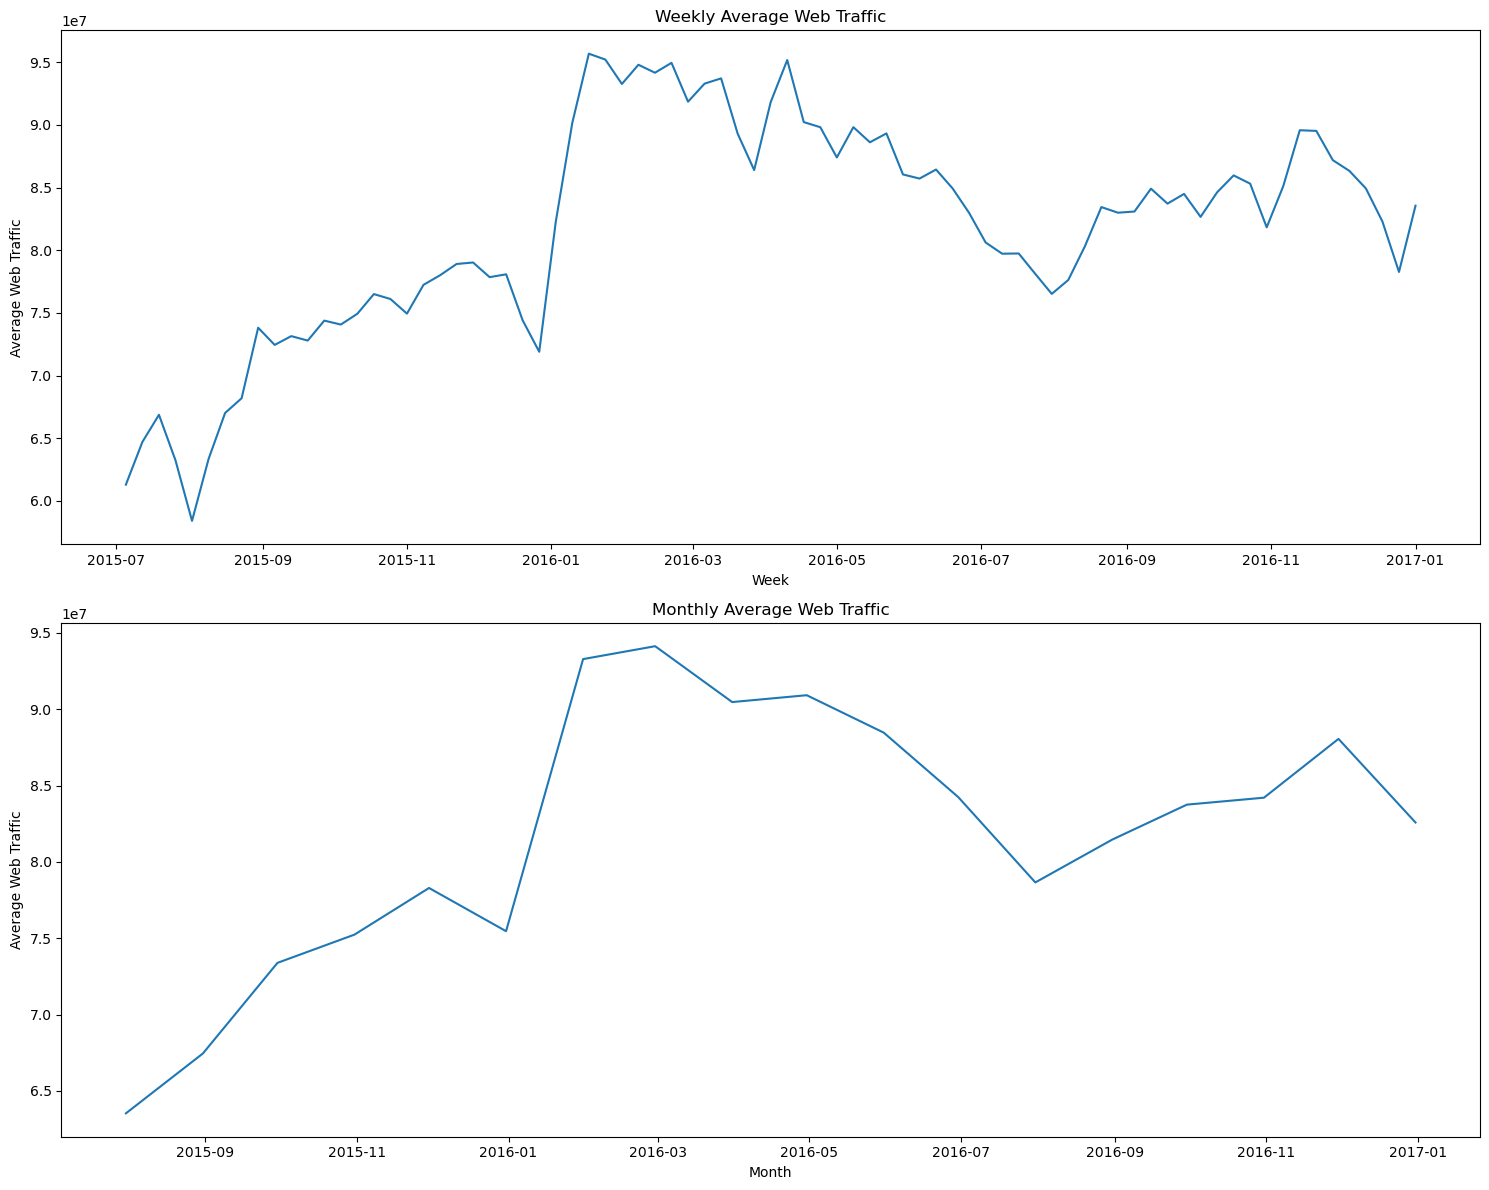

In [6]:
import numpy as np

# Aggregating the data to get overall trends
# Summing up the views across all articles for each date
aggregate_traffic = data_capped.iloc[:, 1:].sum()

# Converting the index to datetime for plotting
aggregate_traffic.index = pd.to_datetime(aggregate_traffic.index)

# Plotting the overall trend
plt.figure(figsize=(15, 6))
sns.lineplot(x=aggregate_traffic.index, y=aggregate_traffic.values)
plt.title('Overall Web Traffic Trend on Wikipedia')
plt.xlabel('Date')
plt.ylabel('Total Web Traffic')
plt.xticks(rotation=45)
plt.show()

# Analyzing Seasonality
# Calculating weekly and monthly averages
weekly_average = aggregate_traffic.resample('W').mean()
monthly_average = aggregate_traffic.resample('M').mean()

# Plotting weekly and monthly averages to observe seasonality
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.lineplot(x=weekly_average.index, y=weekly_average.values, ax=ax[0])
ax[0].set_title('Weekly Average Web Traffic')
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Average Web Traffic')

sns.lineplot(x=monthly_average.index, y=monthly_average.values, ax=ax[1])
ax[1].set_title('Monthly Average Web Traffic')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Web Traffic')

plt.tight_layout()
plt.show()


## Visualizing the Distribution of Average Web Traffic per Article

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


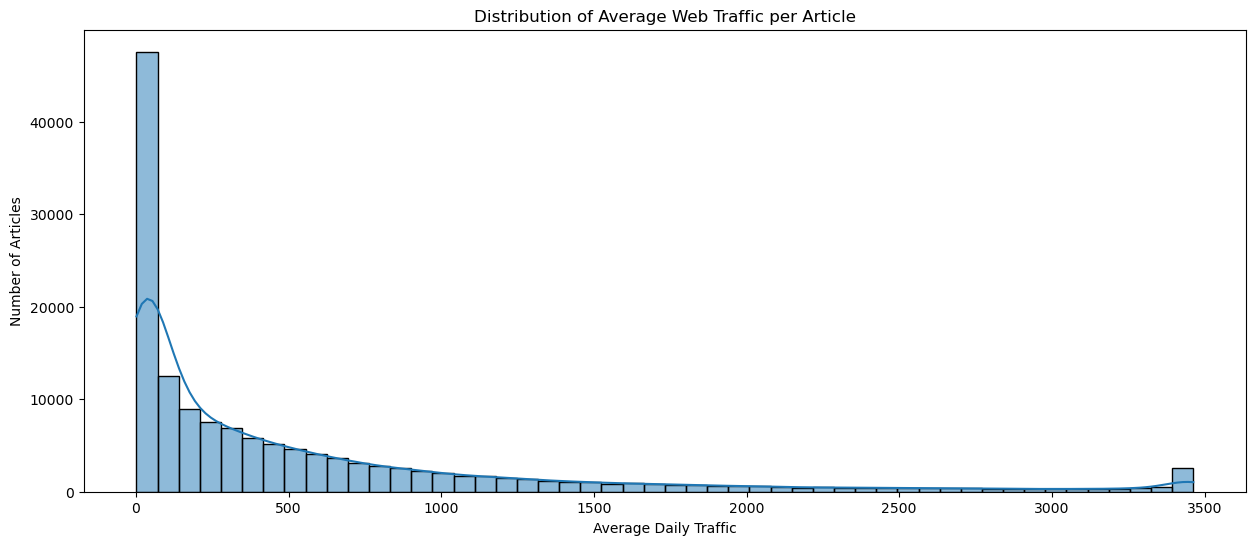

In [7]:

# Calculating the mean traffic for each article across all days
mean_traffic_per_article = data_capped.iloc[:, 1:].mean(axis=1)

# Plotting the distribution of average traffic per article
plt.figure(figsize=(15, 6))
sns.histplot(mean_traffic_per_article, bins=50, kde=True)
plt.title('Distribution of Average Web Traffic per Article')
plt.xlabel('Average Daily Traffic')
plt.ylabel('Number of Articles')
plt.show()


# ARIMA

In [8]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import random


def arima_model(time_series, webpage):
    #Train-Test Split
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]

    #ARIMA Model
    model = ARIMA(train, order=(5, 1, 2))  # Adjust order as needed

    #Model Training
    model_fit = model.fit()

    #Model Validation
    predictions = model_fit.forecast(steps=len(test))

    #Forecasting
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train.values, label='Train')
    plt.plot(test.index, test.values, label='Test')
    plt.plot(test.index, predictions, label='ARIMA Forecast')
    plt.title('ARIMA Forecasting for Web Traffic for '+ webpage)
    plt.xlabel('Date')
    plt.ylabel('Web Traffic')
    plt.legend()
    plt.show()


/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/s

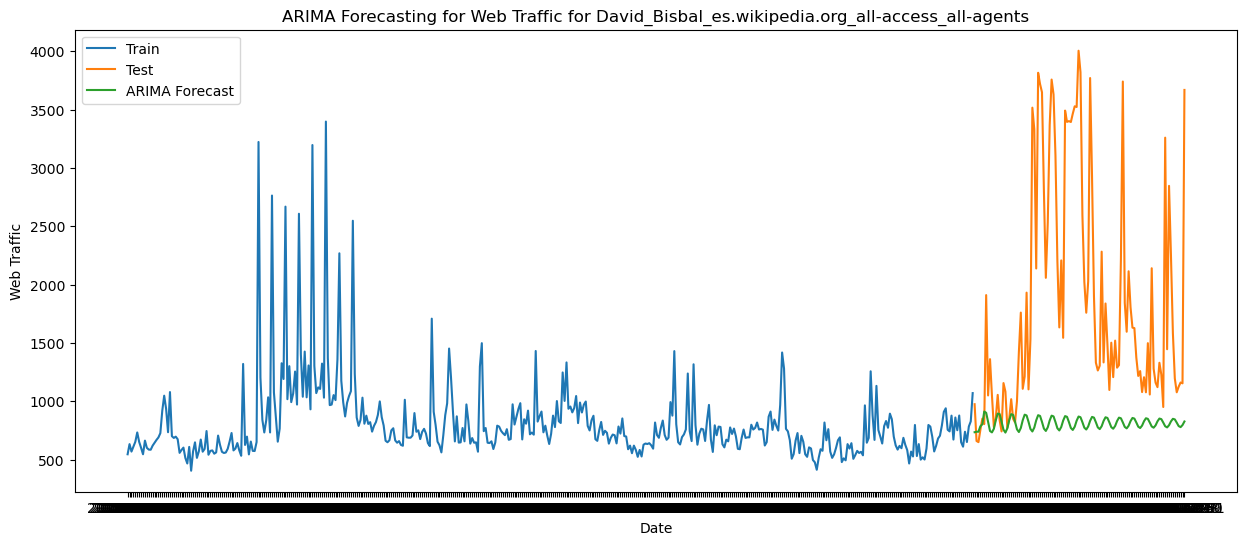

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38364 (\N{CJK UNIFIED IDEOGRAPH-95DC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph

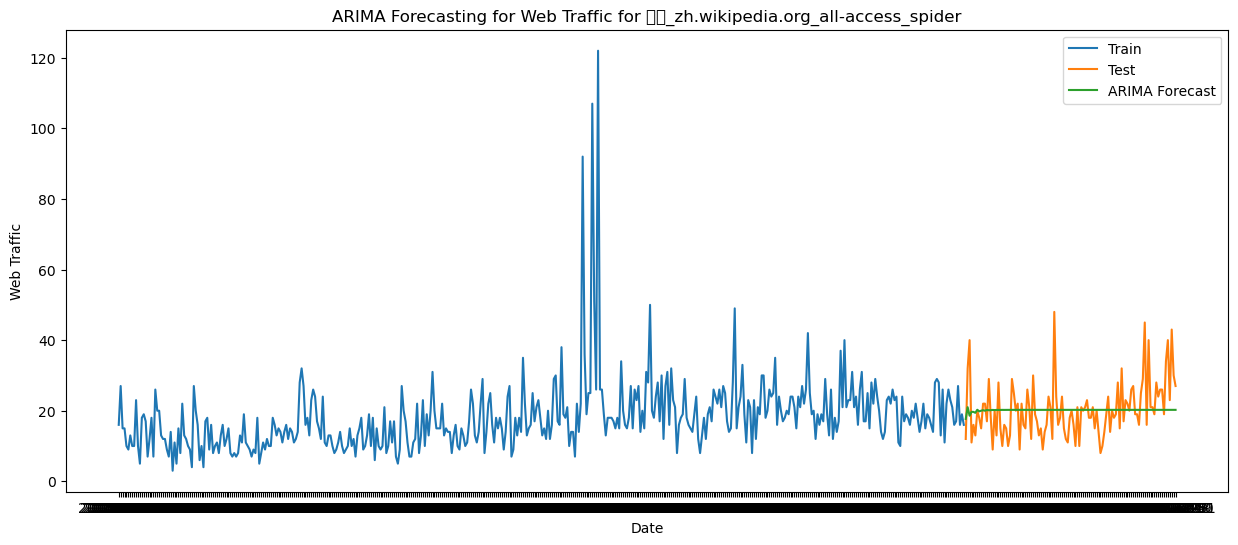

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph

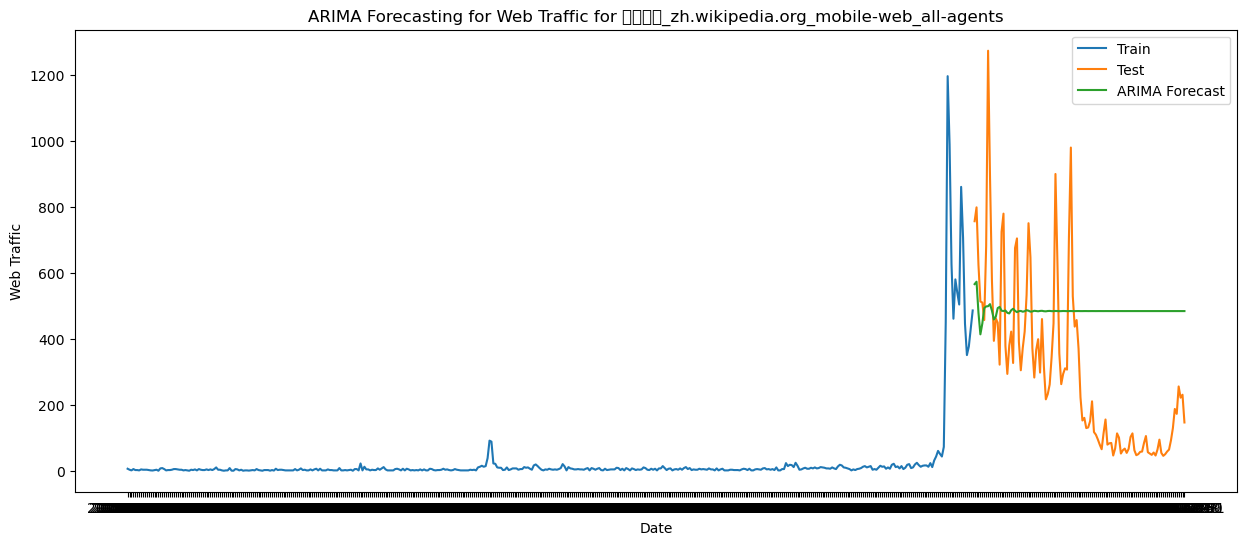

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


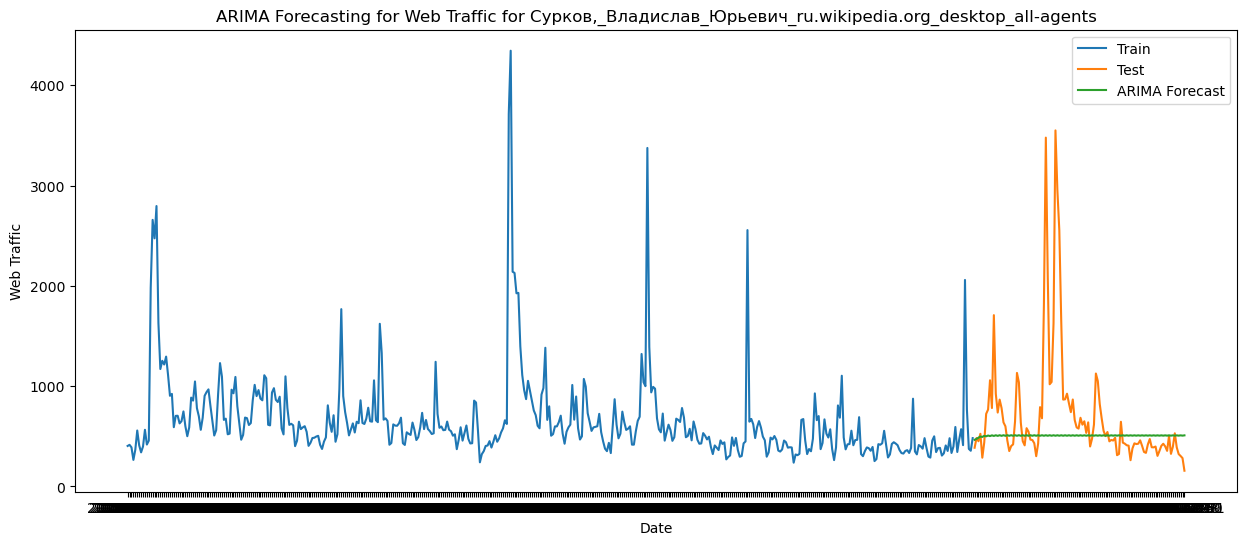

/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rishikeshkakde/anaconda3/lib/python3.11/site-packages/s

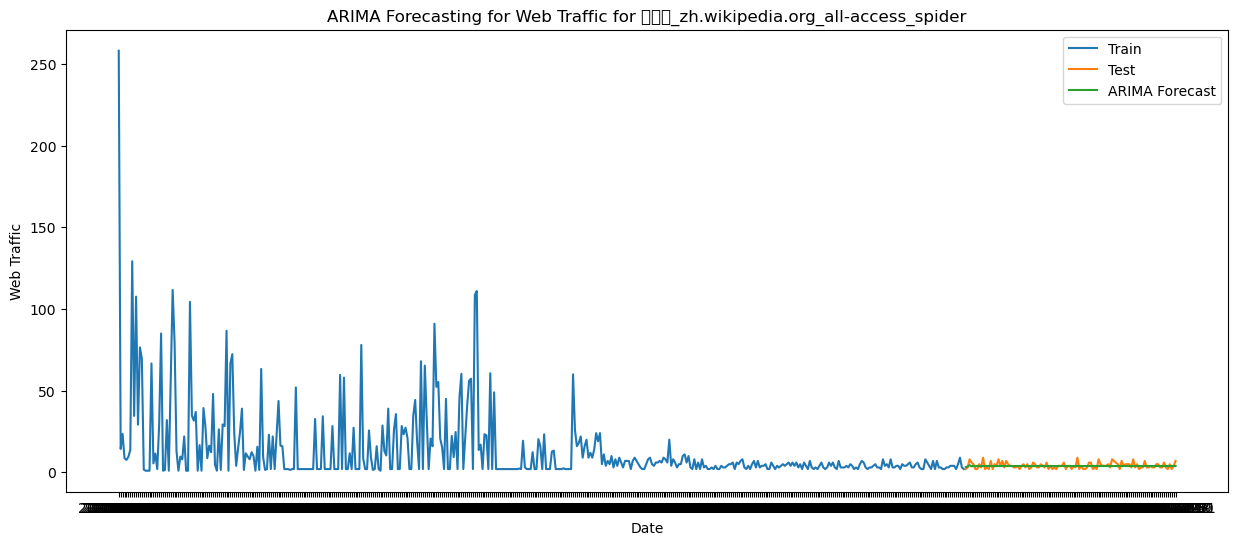

In [9]:
for i in range(5):
    random_page = random.choice(data_capped['Page'])
    time_series = data_capped[data_capped['Page'] == random_page].iloc[:, 1:].squeeze()
    arima_model(time_series,random_page)

# LSTM

550000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
430/430 [==============================] - 223s 515ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 2/10
430/430 [===================

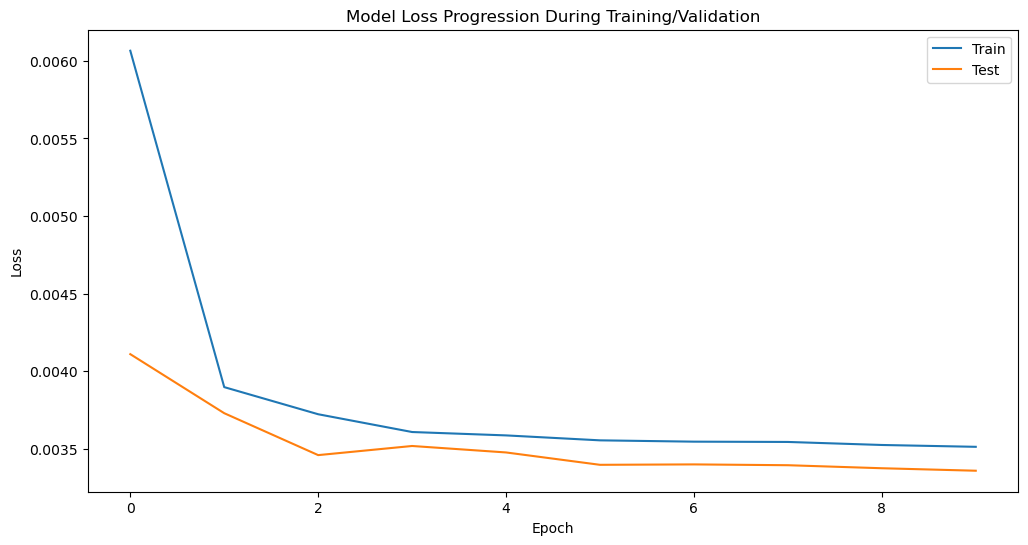

Mean Squared Error: 0.0033584849443286657


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

data_capped = data_capped.sample(n=1000, random_state=42)
data = data_capped.iloc[:, 1:].fillna(0)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))
print(len(data_scaled))

# Function to create a dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time step
time_step = 100
X, y = create_dataset(data_scaled, time_step)

# Reshape input to [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=1024, verbose=1)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss Progression During Training/Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print("Mean Squared Error:", mse)